<a href="https://colab.research.google.com/github/jollygoodjacob/NASA-Space-Apps-Workshop-2024/blob/main/NASA_SpaceApps_Workshop_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA SpaceApps Workshop 2024 - Data Download Tutorial



## Downloading NASA spatial datasets from NASA Earthdata
In this tutorial, you will learn how to download NASA datasets through NASA Earthdata and the earthaccess Python API. We will demonstrate the earthaccess API's use through an exploration of 30m elevation data from the Shuttle Radar Topography Mission (SRTM) over the Russian River watershed.

### Sign up for NASA Earthdata
For many of the challenges, NASA Earthdata will be pivotal for obtaining data from NASA that pertains to your challenge. NASA’s Earthdata is your gateway to one of the planet’s largest repositories of Earth observation data. These data – along with the tools for analyzing and working with these data – are available to you fully, openly, and without restriction.

Just follow these simple steps to create an Earthdata Login for yourself.

1. Go to the Earthdata Login web site, and click on the 'Register' button
2. Enter your information. Only a few fields are mandatory, and these are marked clearly with red dots.
3. Once you have entered your details, click on the green 'Register for Earthdata Login' button at the bottom.
4. To complete the registration, you will now need to go to your email inbox and look for an email similar to the email below. You can activate your account by clicking the activation link provided in the email. Your account must be active before you can login.
5. The link provided in the email should redirect you to NASA Earthdata's activation page. You have now successfully activated your earthdata login account.


### Import required packages
To begin, we need to install a few packages into our Google Colab session prior to running through the tutorial.

In [ ]:
!pip install earthaccess
!pip install rasterio

Next, we will want to import the necessary packages.

In [ ]:
# Import Required Packages
import earthaccess
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from shapely.geometry import box
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import rioxarray as rxr

### Prepare a search area

While there are many ways to search for data through the earthaccess API, one effective way to search for data is to predefine an area of interest or study extent. Then, we can search for relevant data to our study.

We can use a combination of geometric operations to obtain a simple outline of our data, which can be used for the search, and to help filter and refine our search results.

First, we’ll load the data using geopandas, making sure to transform from the original CRS to WGS84 latitude/longitude (epsg=4326):

In [ ]:
russian_huc8 = gpd.read_file("https://raw.githubusercontent.com/jollygoodjacob/NASA_SpaceApps_Workshop_2024/master/russian_huc8.shp").to_crs(epsg=4326)

<ipython-input-97-a1755416d225>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  outline = russian_huc8['geometry'].unary_union


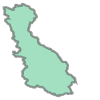

In [ ]:
# gets a single polygon (or multipolygon) composed of the individual polygons
outline = russian_huc8['geometry'].unary_union
outline

We often want to simplify our polygon prior to use in NASA Earthdata (or most APIs), as they tend to not like complex geometries.

We can  obtain the spatial extent of the shapefile using the .bounds command. However, we can also pass a polygon argument. Rather than pass the outline (a very complicated geometric object), though, we’ll look at one additional attribute of a shapely Polygon that we can use to get a bounding box of the geometry - the minimum_rotated_rectangle (documentation) Then, from these coordinates, we can create a rectangle that specifies the minimum extent encompassing our shapefile of the Russian River.

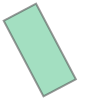

In [ ]:
outline.bounds # get the min x, min y, max x, max y values of the polygon

# gets the minimum rotated rectangle that covers the outline
search_area = outline.minimum_rotated_rectangle

search_area # again, in a jupyter notebook, this displays the polygon

The API that earthaccess uses requires that the Polygon be oriented counter-clockwise. To do this, we can use shapely.geometry.polygon.orient()

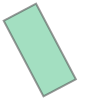

In [ ]:
search_area = shapely.geometry.polygon.orient(search_area, sign=1) # a sign of 1 means oriented counter-clockwise

search_area # this doesn't actually change the geometry, just the order of the vertices

### Searching and Downloading NASA Earthdata Datasets using the earthaccess API

In [ ]:

auth = earthaccess.login(strategy="interactive", persist=True)

# Thanks to NSIDC for the earthaccess package. See https://github.com/nsidc/earthaccess
# for more details.

For this example, we’ll use the following arguments for the search:

**short_name:** the dataset short name. For a full list of available datasets, check the LPDAAC Data Catalog

**polygon:** a list of (lon, lat) tuples to use for spatial filtering

**count:** the maximum number of search results to return

To see what additional arguments are available, you can check the GranuleQuery API reference for additional keywords to use, based on the listed methods for the GranuleQuery class.

In [ ]:
results = earthaccess.search_data(
    short_name="SRTMGL1",
    version="003",# search for STRM 30m v003 granules
    polygon=search_area.exterior.coords#, # search for images that intersect our search_area
    #count=10 # only show the first 10 results
)

In [ ]:
len(results) # show the length of the results list


4

In [ ]:
granule = next(iter(results)) # get the "first" item from the list
granule # show the first item

Collection: {'ShortName': 'SRTMGL1', 'Version': '003'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -123.00027778, 'EastBoundingCoordinate': -121.99972222, 'NorthBoundingCoordinate': 39.00027778, 'SouthBoundingCoordinate': 37.99972222}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-02-11T00:00:00.000Z', 'EndingDateTime': '2000-02-21T23:59:59.000Z'}}
Size(MB): 11.1448
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/SRTMGL1.003/N38W123.SRTMGL1.hgt/N38W123.SRTMGL1.hgt.zip']

In [ ]:
# Download the data to a specified directory
files = earthaccess.download(results,"/content/srtm")


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

### Unzipping Data

Oftentimes, the data downloaded from NASA Earthdata is zipped. If we want to work with these datasets, we need to unzip them.

The following script will:

1.) unzip the downloaded data from the directory you saved the data to

2.) Save the full path names to a lsit that we can use to further process the data

In [ ]:
# Step 5: Unzip the downloaded files
unzipped_files = []
for file in files:
    if file.endswith('.zip'):
        with zipfile.ZipFile(file, 'r') as zip_ref:
            # Extract files to the directory of the zip file
            extract_path = os.path.dirname(file)
            zip_ref.extractall(extract_path)

            # Retain full paths of the extracted files
            for extracted_file in zip_ref.namelist():
                # Construct the full file path
                full_path = os.path.join(extract_path, extracted_file)
                unzipped_files.append(full_path)


### Mosaicking Imagery

We have a total of 4 granules over our area of interest, each of which contains continuous elevation data over part of our watershed of interest. However, we probably would like to work with the data as a single, seamless mosaic.

The following code merges the 4 granules into a single seamless mosaic to work with.

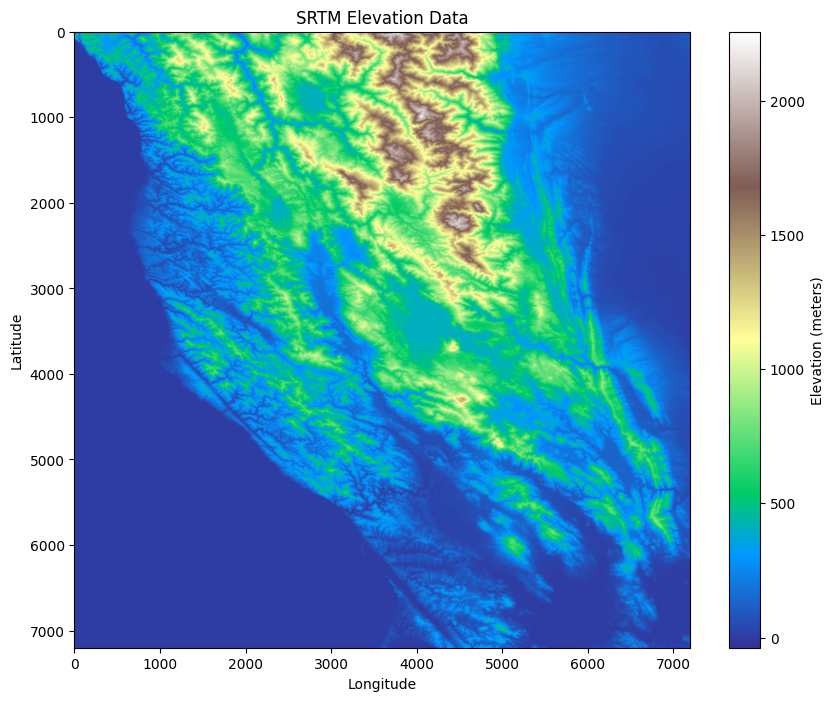

In [ ]:
# Step 6: Mosaic all the GeoTIFF files
src_files_to_mosaic = []

for hgt_file in unzipped_files:
    if hgt_file.endswith('.hgt'):
        src = rasterio.open(hgt_file)
        src_files_to_mosaic.append(src)

# Merge all the files
mosaic, out_trans = rasterio.merge.merge(src_files_to_mosaic)

#Plot the mosaicked imagery
plt.figure(figsize=(10, 8))
plt.title("SRTM Elevation Data")
plt.imshow(mosaic[0], cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Reproject and Crop Imagery to Study Area

We often want to clip these mosaics to our area of interest, as it reduces the overhead on subsequent raster processing and also makes our data map ready for our study area.

However, before we do this, we need to make sure our SRTM data has the same coordinate reference system as the Russian River watershed polygon, else the cropping operation will fail.

Let's apply a useful function to perform this coordinate projection task:

TypeError: 'DatasetReader' object is not subscriptable

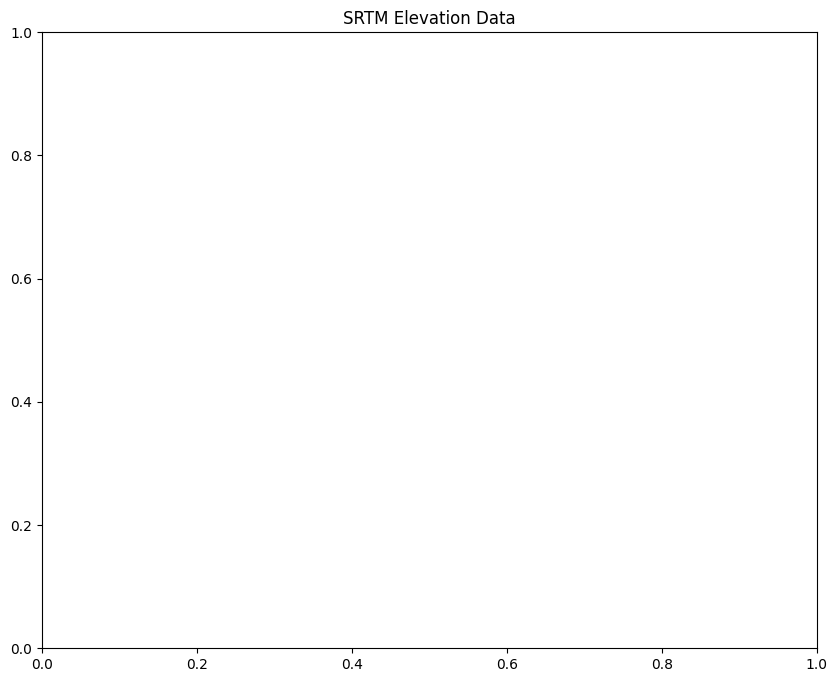

In [ ]:
def reproject_raster(src_path, dst_path, dst_crs):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

# Example usage
src_path = 'mosaic.tif'
dst_path = 'reprojected_mosaic.tif'
dst_crs = 'EPSG:4326'  # Destination CRS (e.g., WGS84)
reproject_raster(src_path, dst_path, dst_crs)

proj_mosaic = rasterio.open("/content/reprojected_mosaic.tif","r")

plt.figure(figsize=(10, 8))
plt.title("SRTM Elevation Data")
plt.imshow(proj_mosaic[0], cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Neat! We solved a particularly insidious problem in spatial sciences with a few lines of code. Now, it's time to crop our raster to our study area.

In [ ]:
# Load the shapefile defining the study area
russian_huc8 = gpd.read_file("https://raw.githubusercontent.com/jollygoodjacob/NASA_SpaceApps_Workshop_2024/master/russian_huc8.shp").to_crs(epsg=4326)

# Function to crop raster to a study area defined by the shapefile
def crop_raster_to_study_area(src_raster_path, dst_raster_path, study_area_gdf):
    # Convert the study area geometry to GeoJSON format
    geometry = [study_area_gdf.geometry.unary_union]

    # Open the raster and apply the mask (crop)
    with rasterio.open(src_raster_path) as src:
        out_image, out_transform = mask(src, geometry, crop=True)
        out_meta = src.meta.copy()

        # Update metadata after cropping
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Save the cropped raster
        with rasterio.open(dst_raster_path, "w", **out_meta) as dst:
            dst.write(out_image)

# Example usage
src_raster_path = 'reprojected_mosaic.tif'  # Path to your mosaic raster
dst_raster_path = 'cropped_mosaic.tif'  # Output path for the cropped mosaic

# Crop the mosaic to the study area defined by the Russian HUC8 shapefile
crop_raster_to_study_area(src_raster_path, dst_raster_path, russian_huc8)

<ipython-input-121-51fd36f662fe>:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = [study_area_gdf.geometry.unary_union]


ValueError: Input shapes do not overlap raster.